# ML RUN2 - Incorporating colour

---

In [1]:
# Load in all the required functions

from socket import gethostname

if gethostname() == 'colonsay':
    PATH_START = '/disk1/rohitk/ELN1_project/'

elif gethostname() == 'rohitk-elitebook':
    PATH_START = '/home/rohitk/Documents/PhD/Year1/ELN1_project/'

# Path start for Max_L analysis
#PATH_START = PATH_START + "OCT17_ELAIS_im/maxl_test/"
    
#################################################
# Add the path of useful functions at the start

import sys

# Import some important functions
#sys.path.append(PATH_START+'../../basic_functions')

# Import coordinate converstion functions
from useful_functions import (coord_matching, nearest_neigh_match, latest_dir, varstat, return_hist_par, field_filter)
#from overlapping_area import (isinpan, isinukidss, isinSWIRE, isinSERVS)
from moc_util import coords_to_hpidx, inMoc
##################################################

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import matplotlib.gridspec as gridspec
#get_ipython().magic(u'matplotlib inline')
#get_ipython().magic(u'pylab inline')

# Set default properties about all figures
from matplotlib import rcParams

rcParams['figure.figsize'] = 10,10
#from matplotlib import rc
# plt.rc('legend',**{'fontsize':16})
rcParams['axes.labelsize'] = 16
rcParams['axes.linewidth'] = 2
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

import time

from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

# Multiprocessin method of doing the ML analysis
import multiprocessing as mp
from functools import partial

from os import makedirs

ts = time.time()
# %pylab inline
import importlib
import os
from time import strftime
from useful_functions import logspace_bins
import glob
import pickle

# For MOC files
import pymoc.io.fits
import healpy as hp
import pymoc.util.catalog

tstart = time.time()

In [2]:
# Load in all the required functions

from socket import gethostname

if gethostname() == 'colonsay':
    PATH_START = '/disk1/rohitk/ELN1_project/'

elif gethostname() == 'rohitk-elitebook':
    PATH_START = '/home/rohitk/Documents/PhD/Year1/ELN1_project/'

# Path start for Max_L analysis
# PATH_START = PATH_START + "OCT17_ELAIS_im/maxl_test/"
    
#################################################
# Add the path of useful functions at the start

import sys

# Import some important functions
#sys.path.append(PATH_START+'basic_functions')

import importlib

# Import coordinate converstion functions
from useful_functions import field_filter, get_overlap_sources, latest_dir, logspace_bins, return_hist_par
#from overlapping_area import (isinpan, isinukidss, isinSWIRE, isinSERVS)
from plot_func import rc_def, make_fig
rc_def()

# For reading in MOC files and filtering catalogues
from moc_util import coords_to_hpidx, inMoc
##################################################

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

import time

from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky


# Multiprocessin method of doing the ML analysis
import multiprocessing as mp
from functools import partial

import pickle

ts = time.time()
# %pylab inline
import matplotlib as mpl
mpl.rcParams["font.size"] = 18
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["axes.labelsize"] = 18

import os
from time import strftime
import glob

# For MOC creation files
import pymoc.io.fits
import healpy as hp
import pymoc.util.catalog
from mocpy import MOC, WCS

In [3]:
# Import ML functions from mlrun1
import mlrun1_bootes
importlib.reload(mlrun1_bootes)


from mlrun1_bootes import (survey_area, get_bin_list, get_n_m, get_q_m, 
                    generate_rand_pos_servs, get_Q0, compute_Fr, get_nm_interp,
                    get_qm_interp, get_lr,
                   get_giK_bin_indices, get_iK_bin_indices,
                   get_qm_c, gen_binc_binl, get_nm_c, generate_rand_pos_bootes, gen_rand_cat_inMOC)

from mlrun1_bootes import (get_n_m_kde, get_q_m_kde, estimate_q_m_kde, get_sigma_all, fr_u)


## Miscellaneous <a class="anchor" id="misc-func"></a>

In [4]:
def completeness(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr < threshold]
    return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/float(n)/q0

def reliability(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr > threshold]
    return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/float(n)/q0

completeness_v = np.vectorize(completeness, excluded=[0])
reliability_v = np.vectorize(reliability, excluded=[0])

def comp_rel_threshold(lr, threshold, q0):
    """
    Function to compute the crossing point of the completeness and reliability graph
    """

    completeness_t = completeness_v(lr, threshold, q0)
    reliability_t = reliability_v(lr, threshold, q0)
    average_t = (completeness_t + reliability_t)/2
    
    # Crossing point of completeness and reliability
    th_cross = threshold[np.argmin(np.abs(completeness_t - reliability_t))]
    
    return th_cross, completeness_t, reliability_t

In [5]:
from matplotlib import cm
from matplotlib.collections import LineCollection


def plot_q_n_m(q_m, n_m):
    fig, a = plt.subplots()

    for i, q_m_k in enumerate(q_m):
        #plot(centers[i], q_m_old[i]/n_m_old[i])
        a = subplot(4,4,i+1)
        if i not in [-1]:
            n_m_aux = n_m[i]/np.sum(n_m[i])
            lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
            #print(lwidths)

            y_aux = q_m_k/n_m[i]
            factor = np.max(y_aux[low:high])
            y = y_aux
            #print(y)
            x = centers[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments, linewidths=lwidths, color=colors[i])

            a.add_collection(lc)

            #plot(centers[i], x/factor, color=colors[i-1])
            xlim([12, 30])
            if i == 0:
                xlim([10, 23])
            ylim([0, 1.2*factor])

    subplots_adjust(left=0.125, 
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.2)
    return fig

In [6]:
def plot_qn_c(bin_centres, magnitude_distribution, outfig_fname):
    """
    Function to plot the n(m,c) and q(m,c) distributions
    
    Parameters:
    -----------
    bin_centres: Bin centres used to compute the n(m,c) distribution
    magnitude_distribution: Magnitude distribution of n(m) or q(m) for each category
    """
    
    fig = plt.subplots(figsize=(11,20))
    ratio = .8
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0.6, hspace=0.5)
        
    for k in range(len(magnitude_distribution)):
        ax = plt.subplot(9,4,k+1)

        # ax = plt.subplot(gs[k])
        plt.plot(bin_centres, magnitude_distribution[k])
        # ax.set_aspect(aspect='equal', adjustable='box')
        
        # Sets the aspect ratio of each subplot
        xvals,yvals = plt.gca().axes.get_xlim(), plt.gca().axes.get_ylim()
        xrange = xvals[1]-xvals[0]
        yrange = yvals[1]-yvals[0]
        plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

        plt.title(col_cat_def[k]["cat"])
    plt.savefig(outfig_fname)
    plt.close() # Doesn't plot the output inline
        
    return

In [7]:
def indx_to_bool(array_of_indices, array_length):
    """
    Convert an array_of_indices into a boolean array of length array_length
    """
    bool_array = np.zeros(array_length, dtype=bool)
    bool_array[array_of_indices] = True
    return bool_array

### PanSTARRS and UKIDSS survey areas <a class="anchor" id="survey-area"></a>

In [8]:
# Survey area definitions - used for generated random catalogue and select the relevant PanSTARRS sources

# PanSTARRS "rectangle box" definition
p_ra_down = 160.2
p_dec_down = 57.2
p_ra_up = 164.1
p_dec_up = 58.5

# UKIDSS survey area

# Get the area of the rectangle used for n(m)
# Get the PanSTARRS area in arcsec
pan_area = survey_area(p_ra_up, p_dec_up, p_ra_down, p_dec_down)
print(pan_area)

34964523.7041


In [97]:
workflow_tier = True

if workflow_tier:
    add_str = "_workflow"
else:
    add_str = ""

In [98]:
# Definition of the paths

PATH_PYBDSF_RAW = 'data/edited_cats/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat_foverlap.fits'
#PATH_MASTER_LIST = "data/EN1_MASTER_opt_spitzer_merged_forML.fits"
PATH_MASTER_LIST = "data/edited_cats/optical/LH_MASTER_opt_spitzer_merged_forLGZ.fits"

In [99]:
# Find the latest ML RUN1 output and read that in
catdir = latest_dir("run1_matches" + add_str + "/*2019*")
print(catdir)

# Select the type of catalogue to load (srl or gaus)
cat_type = "_srl"
field = "EN1"

PATH_RUN1_MATCHES = catdir + '/' + field + '_ML_RUN1' + cat_type + '_nanth.fits'

run1_matches_workflow/21_06_2019_1


In [100]:
print(PATH_RUN1_MATCHES)

run1_matches_workflow/21_06_2019_1/EN1_ML_RUN1_srl_nanth.fits


In [101]:
# Load the master and the RUN1 matches
master =  Table.read(PATH_MASTER_LIST, format='fits')

In [102]:
'''# Read in the MOC file
PATH_MOC = "/disk3/rohitk/ELAIS_opt_swarped/moc_files/stitch_moc/final_mocs/EL_EN1_i_K_sw2_with_add.fits"

# Generate a MOC class instance first
cata_moc = pymoc.MOC()
pymoc.io.fits.read_moc_fits(cata_moc, PATH_MOC)

moc_area = cata_moc.area_sq_deg
print("Area of MOC: {0} sq. deg.".format(moc_area))'''

'# Read in the MOC file\nPATH_MOC = "/disk3/rohitk/ELAIS_opt_swarped/moc_files/stitch_moc/final_mocs/EL_EN1_i_K_sw2_with_add.fits"\n\n# Generate a MOC class instance first\ncata_moc = pymoc.MOC()\npymoc.io.fits.read_moc_fits(cata_moc, PATH_MOC)\n\nmoc_area = cata_moc.area_sq_deg\nprint("Area of MOC: {0} sq. deg.".format(moc_area))'

In [103]:
# Load in the MOCs
PATH_MOC_r = "data/edited_cats/optical/mocs/LH_r_moc_order_18_MOC_with_add.fits"
PATH_MOC_se2 = "data/edited_cats/optical/mocs/LH_se2_moc_order_18_MOC.fits"
PATH_MOC_sw2 = "data/edited_cats/optical/mocs/LH_sw2_moc_order_18_MOC.fits"

moc_r = pymoc.MOC()
pymoc.io.fits.read_moc_fits(moc_r, PATH_MOC_r)

moc_se2 = pymoc.MOC()
pymoc.io.fits.read_moc_fits(moc_se2, PATH_MOC_se2)

moc_sw2 = pymoc.MOC()
pymoc.io.fits.read_moc_fits(moc_sw2, PATH_MOC_sw2)

print("Area of r-MOC: {0} sq. deg.".format(moc_r.area_sq_deg))
print("Area of se2-MOC: {0} sq. deg.".format(moc_se2.area_sq_deg))
print("Area of sw2-MOC: {0} sq. deg.".format(moc_sw2.area_sq_deg))

Area of r-MOC: 13.321917803932173 sq. deg.
Area of se2-MOC: 5.574102257180664 sq. deg.
Area of sw2-MOC: 10.949807996199757 sq. deg.


## Define the optical and IR magnitude columns for SNR calculations

In [104]:
# Define the magnitude/flux columns to use for optical and Spitzer data
opt_ap = "2"  # 3'' aperture magnitude
mid_ap = "2"  # 4'' aperture magnitude


opt_fl_col = "FLUX_APER_r_" + opt_ap
opt_efl_col = "FLUXERR_APER_r_" + opt_ap
opt_mag_col = "MAG_APER_r_" + opt_ap

mir_fl_col = "FLUX_APER_sw2_" + mid_ap
mir_efl_col = "FLUXERR_APER_sw2_" + mid_ap
mir_mag_col = "MAG_APER_sw2_" + mid_ap

snr_th = 3

# Condition based on overlapping area of all thee surveys
overlap_cond = master["FLAG_OVERLAP"] == 3

# Compute SNR of i and K band
snr_i = master[opt_fl_col] / master[opt_efl_col]
i_det = np.copy((snr_i >= snr_th) & (overlap_cond))

snr_ir = master[mir_fl_col] / master[mir_efl_col]
ir_det = np.copy((snr_ir >= snr_th) & (overlap_cond))

opt_ir_sources = i_det & ir_det & overlap_cond

In [105]:
print(np.sum((snr_ir >= snr_th) & (overlap_cond)))
print(np.sum(np.copy((snr_ir >= snr_th) & (overlap_cond))))
print(np.sum((snr_i >= snr_th) & (overlap_cond)))
print(np.sum(np.copy((snr_i >= snr_th) & (overlap_cond))))


564452
564452
1465714
1465714


In [106]:
# Over-ride the aperture to use after doing the SNR calculation
opt_ap = "3"  # 3'' aperture magnitude
mid_ap = "4"  # 4'' aperture magnitude

opt_fl_col = "FLUX_APER_r_" + opt_ap
opt_efl_col = "FLUXERR_APER_r_" + opt_ap
opt_mag_col = "MAG_APER_r_" + opt_ap

mir_fl_col = "FLUX_APER_sw2_" + mid_ap
mir_efl_col = "FLUXERR_APER_sw2_" + mid_ap
mir_mag_col = "MAG_APER_sw2_" + mid_ap

# Compute the i-K colour for these soruces
master["ich2_col_o"] = np.nan
master["ich2_col_o"][opt_ir_sources] = master[opt_mag_col][opt_ir_sources] - master[mir_mag_col][opt_ir_sources]

print("SNR > 3 in r: {0}".format(np.sum(i_det)))
print("SNR > 3 in ch2: {0}".format(np.sum(ir_det)))
print("SNR > 3 in and r and ch2: {0}".format(np.sum(opt_ir_sources)))

# varstat(master[opt_mag_col][opt_ir_sources])
# varstat(master[mir_mag_col][(snr_i < 3) & (snr_i > 1.)])

SNR > 3 in r: 1465714
SNR > 3 in ch2: 564452
SNR > 3 in and r and ch2: 444304


In [107]:
"""SNR > 3 in i: 1606750
SNR > 3 in ch2: 1084915
SNR > 3 in and i and ch2: 891001""";

### (2) i-only and $4.5 \mu m$-only sources

In [108]:
# Define these as sources with snr_i < 3 or snr_K < 3

i_only = (i_det & ~ir_det)
ir_only = (ir_det & ~i_det)

print("r-only sources: {0}".format(np.sum(i_only)))
print("ch2-only sources: {0}".format(np.sum(ir_only)))

r-only sources: 1021410
ch2-only sources: 120148


In [109]:
np.sum(ir_det & ~opt_ir_sources)

120148

In [110]:
print("No. of r-ch2 sources: {0}".format(np.sum(opt_ir_sources)))
print("No. of r-only sources: {0}".format(np.sum(i_only)))
print("No. of ir-only sources: {0}".format(np.sum(ir_only)))
print("=========================================")

ncol_tot = np.sum(opt_ir_sources | i_only | ir_only)
ncol_tot_ov = np.sum((master["FLAG_OVERLAP"] ==3) & (opt_ir_sources | i_only | ir_only))

print("Total no. of sources: {0}, {1:5.3}%".format(ncol_tot, ncol_tot/len(opt_ir_sources)*100))
print("Total no. of sources in overlap region: {0}, {1:5.3}%".format(ncol_tot_ov, ncol_tot_ov/np.sum(master["FLAG_OVERLAP"]==7)*100))
# cat_inmoc = inMoc(master["ALPHA_J2000"], master["DELTA_J2000"], cata_moc)

print("No. of sources in the overlapping region of PS, DXS and SWIRE: {0}".format(np.sum(master["FLAG_OVERLAP"] == 7)))

# print("No. of sources in MOC: {0}".format(np.sum(cat_inmoc)))
print("No. of sources in OVERLAP and in some colour category: {0}".format(np.sum((master["FLAG_OVERLAP"] ==7) & (opt_ir_sources | i_only | ir_only))))

No. of r-ch2 sources: 444304
No. of r-only sources: 1021410
No. of ir-only sources: 120148
Total no. of sources: 1585862,  52.1%
Total no. of sources in overlap region: 1585862,   inf%
No. of sources in the overlapping region of PS, DXS and SWIRE: 0
No. of sources in OVERLAP and in some colour category: 0


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [111]:
ncol_tot/np.sum(master["FLAG_OVERLAP"]==3)*100

80.84244546738239

In [112]:
nocat_bool = ((master["FLAG_OVERLAP"] == 3) & ~(opt_ir_sources | i_only | ir_only))
print(np.sum(nocat_bool))
print("No. of sources in OVERLAP and NOT in ANY colour category: {0}".format(np.sum((master["FLAG_OVERLAP"] ==7) & ~(opt_ir_sources | i_only | ir_only))))

375808
No. of sources in OVERLAP and NOT in ANY colour category: 0


In [113]:
# Do a consistency check
all_cat_totals = np.sum((opt_ir_sources | i_only | ir_only | nocat_bool)  & (master["FLAG_OVERLAP"] == 3))
print("Total no. of sources in all categories (incl. no-mag): {0}, {1}".format(all_cat_totals, all_cat_totals/np.sum(master["FLAG_OVERLAP"] == 3)))

Total no. of sources in all categories (incl. no-mag): 1961670, 1.0


In [114]:
full_indices = np.arange(len(master))

olap_ind = full_indices[overlap_cond]
opt_ir_ind = full_indices[opt_ir_sources]
opt_ind = full_indices[i_only]
ir_ind = full_indices[ir_only]
nocat_ind = full_indices[nocat_bool]

In [115]:
len(olap_ind), len(opt_ir_ind) + len(opt_ind) + len(ir_ind) + len(nocat_ind)

(1961670, 1961670)

In [116]:
del full_indices, olap_ind, opt_ir_ind, opt_ind, ir_ind, nocat_ind

In [117]:
# Get the area of the rectangle used for n(m)
pan_area = survey_area(p_ra_up, p_dec_up, p_ra_down, p_dec_down)
print(pan_area)

ind_rect = field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, master["ALPHA_J2000"], master["DELTA_J2000"])

# nocat_bool = ((master["FLAG_OVERLAP"] ==7) &  ~(opt_ir_sources | i_only | ir_only))
print(np.sum(nocat_bool))

nm_nocat = np.sum(nocat_bool & ind_rect) / pan_area
# nm_nocat = np.sum(i_only) / pan_area
print("n(c) of the no calour category: {0}".format(nm_nocat))

34964523.7041
375808
n(c) of the no calour category: 0.0026183968863668795


# Get the i-K colour bins indices and create the colour groupings

In [118]:
# Separate the objects into the i-K colour indices

# Colour bin width
col_bin_width = 0.2

iK_col_bins = np.arange(-1.5, 4.5+0.5, 0.5)
iK_col_bins[0] = -50. # Some very small small such that the i-K < 3 bin can be calculated
iK_col_bins[-1] = 50.

large_binw = 0.5
small_binw = 0.25

iK_col_bins = []
mid_iK_col_bins = list(np.arange(-1+small_binw, 4.2+small_binw, small_binw))
iK_col_bins.extend(mid_iK_col_bins)
iK_col_bins[0] = -40

# iK_col_bins.extend(list(np.arange(1.5+large_binw, 5.0, large_binw)))
iK_col_bins[-1] = 40

iK_col_bins = np.array(iK_col_bins)

print("i-K bins: ")
print(iK_col_bins)


i-K bins: 
[-40.    -0.5   -0.25   0.     0.25   0.5    0.75   1.     1.25   1.5
   1.75   2.     2.25   2.5    2.75   3.     3.25   3.5    3.75   4.    40.  ]


In [119]:
def get_iK_bin_indices(iK_bin_list, iK_colours):
    """
    Get the indices of objects in each giK colour bins 
    10 i-K colour bins --> further divided into 2 equal g-i colour halves
    
    Parameters:
    -----------
    
    iK_bin_list : Bin list of i-K colours
    iK_colours : i-K colour of the sources to be binned
    
    Returns:
    --------
    iK_ind : Indices in each i-K bin, a list of bool arrays
    """
    
    # List of boolean arrays (each of length=len(iK_digitize))
    iK_all_ind = []
    # List of boolean arrays  - BUT each array has length = len(master) - so it an be used for indexing
    iK_full_ind = []

    # Loop counter
    count = 0
    
    # Gives indices of objects in each bin
    for k in range(len(iK_bin_list)-1):
        
        # Bool array of colours within the jth and jth+1 bin
        iK_full_ind.append((iK_colours >= iK_bin_list[k]) & (iK_colours < iK_bin_list[k+1]))
        
    return iK_full_ind # Don't actually need to return iK_all_ind

# Full master indices
master_indices_arr = np.arange(len(master))
# iKcol_master_ind = master_indices_arr[iK_sources]

iK_ind = get_iK_bin_indices(iK_col_bins, master["ich2_col_o"])

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


### Define the non-colour categories here

In [120]:
print("**** i-4.5 colour bins and master catalogue sources *****")
print("{0} i-4.5 colour categories".format(len(iK_col_bins)-1))
for k in range(len(iK_ind)):
    print("{0} < {1}: {2}".format(iK_col_bins[k], iK_col_bins[k+1], np.sum(iK_ind[k])))

**** i-4.5 colour bins and master catalogue sources *****
20 i-4.5 colour categories
-40.0 < -0.5: 10485
-0.5 < -0.25: 5137
-0.25 < 0.0: 7871
0.0 < 0.25: 10846
0.25 < 0.5: 14601
0.5 < 0.75: 18594
0.75 < 1.0: 22804
1.0 < 1.25: 26284
1.25 < 1.5: 29222
1.5 < 1.75: 31447
1.75 < 2.0: 32875
2.0 < 2.25: 33651
2.25 < 2.5: 33065
2.5 < 2.75: 31430
2.75 < 3.0: 29271
3.0 < 3.25: 25973
3.25 < 3.5: 22032
3.5 < 3.75: 17856
3.75 < 4.0: 13671
4.0 < 40.0: 27121


In [121]:
# Make a list of the "non-colour" colour categories from the above classifications and the string corresponding to the category
"""no_col_group_str = ["iK_only", "gi_only", "i_only", "ir_only"]  # This is used for making the colour categories dictionary

non_col_group = []
non_col_group.append(iK_only)
non_col_group.append(gi_only)
non_col_group.append(new_ionly)
non_col_group.append(ir_only)""";

no_col_group_str = ["i_only", "ir_only", "no_mag"]  # This is used for making the colour categories dictionary

non_col_group = []
non_col_group.append(i_only)
non_col_group.append(ir_only)
non_col_group.append(nocat_bool)

In [122]:
# Make a list of the legends for the plots later on
col_cat_legend = []

for k in range(len(iK_ind)):
    col_cat_legend.append(r"${{{low}}} < (i-4.5) \leq {{{max}}}$".format(low=iK_col_bins[k], max=iK_col_bins[k+1]))
    
# Add the i-only, ir-only and no-mag category
no_col_group_str_latex = ["i-only", "4.5-only"]
for estr in no_col_group_str_latex:
    col_cat_legend.append(r"${{{lstr}}}$".format(lstr=estr))

print(col_cat_legend)

['${-40.0} < (i-4.5) \\leq {-0.5}$', '${-0.5} < (i-4.5) \\leq {-0.25}$', '${-0.25} < (i-4.5) \\leq {0.0}$', '${0.0} < (i-4.5) \\leq {0.25}$', '${0.25} < (i-4.5) \\leq {0.5}$', '${0.5} < (i-4.5) \\leq {0.75}$', '${0.75} < (i-4.5) \\leq {1.0}$', '${1.0} < (i-4.5) \\leq {1.25}$', '${1.25} < (i-4.5) \\leq {1.5}$', '${1.5} < (i-4.5) \\leq {1.75}$', '${1.75} < (i-4.5) \\leq {2.0}$', '${2.0} < (i-4.5) \\leq {2.25}$', '${2.25} < (i-4.5) \\leq {2.5}$', '${2.5} < (i-4.5) \\leq {2.75}$', '${2.75} < (i-4.5) \\leq {3.0}$', '${3.0} < (i-4.5) \\leq {3.25}$', '${3.25} < (i-4.5) \\leq {3.5}$', '${3.5} < (i-4.5) \\leq {3.75}$', '${3.75} < (i-4.5) \\leq {4.0}$', '${4.0} < (i-4.5) \\leq {40.0}$', '${i-only}$', '${4.5-only}$']


### Make a dictionary of colour categories (for the 29 defined categories) <a class="anchor" id="dict_col_cat"></a>

In [123]:
# Make a dictionary of the colour categories

col_cat_def = []
# Build up the dictionary for each of the 29 categories

# Initialise with the 1st category (both lower and upper giK half)
col_cat_def = [{"cat_no":0, "cat":"i45_1",
                "condition":iK_ind[0]}]

############### For the 20 giK colour categories ###############

for k in range(1, len(iK_ind)):
    
    col_cat_def.append({"cat_no":col_cat_def[-1]['cat_no']+1,    # Add 1 to the previous category number
                        "cat":"i45_" + str(k+1),               # Edit the unique category identifier
                        "condition":iK_ind[k]})              # Append the gi <= median bool array

###############  For the non-colour categories #################

# The unique string identifying each of the non-colour categories
# non_col_group_str = ["i_only", "ir_only"]  # This is used for making the colour categories dictionary

for k in range(len(non_col_group)):
    
    col_cat_def.append({"cat_no":col_cat_def[-1]['cat_no']+1,
                        "cat":no_col_group_str[k],
                        "condition":non_col_group[k]})

# Print the numbers in each category    
test = []
print("Category # Sources       Cat no.")
for item in col_cat_def:
    print("{0} \t {1}       {2}".format(item['cat'], np.sum(item["condition"]), item["cat_no"]))
    test.append(np.sum(item["condition"]))

print("====================================================")
print("Total no. of sources in ANY category: {0}".format(np.sum(test)))

# Strings of all categories
all_cat = [a['cat'] for a in col_cat_def]
# Total numbers in each colour category
tot_numbers = np.array([np.sum(a["condition"]) for a in col_cat_def])


# For each source in the master catalogue, assign it a category
master["cat_no"] = np.nan
for aa in col_cat_def:
    
    # Assign value=aa wherever the "condition" of the source evaluates to true
    # i.e. if a row in col_cat_def["condition"][aa] == True, assign it the master["cat_no"] = aa
    master["cat_no"][aa["condition"]] = aa["cat_no"]

# Number of master sources not in any category
print("No. of MASTER sources not in any category: " + str(np.sum(np.isnan(master["cat_no"]))))
print("No. of MASTER sources in MOC but with NO colour category: {0}".format(np.sum((master["FLAG_OVERLAP"]==3) & np.isnan(master["cat_no"]))))
#master.write('MASTER_LIST_0418_with_mag_ccat', format='ascii')

Category # Sources       Cat no.
i45_1 	 10485       0
i45_2 	 5137       1
i45_3 	 7871       2
i45_4 	 10846       3
i45_5 	 14601       4
i45_6 	 18594       5
i45_7 	 22804       6
i45_8 	 26284       7
i45_9 	 29222       8
i45_10 	 31447       9
i45_11 	 32875       10
i45_12 	 33651       11
i45_13 	 33065       12
i45_14 	 31430       13
i45_15 	 29271       14
i45_16 	 25973       15
i45_17 	 22032       16
i45_18 	 17856       17
i45_19 	 13671       18
i45_20 	 27121       19
i_only 	 1021410       20
ir_only 	 120148       21
no_mag 	 375808       22
Total no. of sources in ANY category: 1961602
No. of MASTER sources not in any category: 1080192
No. of MASTER sources in MOC but with NO colour category: 68


In [124]:
# List of magnitude column names - fn_opt_indices in apply_ml(*args) function
mag_col_name = []

for a in range(len(col_cat_def)):
    
    if col_cat_def[a]["cat"][:4] == 'i45_' or col_cat_def[a]["cat"] == 'i_only':
        # i.e. if the category is either i-4.5 colour or i_only, then use the i-band colour
        mag_col_name.append(opt_mag_col)
        
    elif col_cat_def[a]["cat"] == 'ir_only':
        mag_col_name.append(mir_mag_col)
        
    elif col_cat_def[a]["cat"] == 'iK_only':
        mag_col_name.append("MAG_APER_K_3")
        
    elif col_cat_def[a]["cat"] == 'gi_only':
        mag_col_name.append(opt_mag_col)
        
    elif col_cat_def[a]["cat"] == "no_mag":
        mag_col_name.append("no_mag")

print("Total no. of colour categories: {0}".format(len(mag_col_name)))
print(mag_col_name)

Total no. of colour categories: 23
['MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_r_3', 'MAG_APER_sw2_4', 'no_mag']


In [125]:
# Function to compute ML based on magnitude of possible conterpart and the sigma

def apply_ml(i):
    """
    Function which combines previous routines to compute ML values 
    for each ith LOFAR source that has a match within 15'' to opt/NIR catalogue
    
    Parameters:
    -----------
    i : Index of the LOFAR coordinates
    fn_opt_indices : Field name of indices in MASTER catalogue
    mean_Q0 : Mean Q0 value for the band
    nm_categ : Cumulative n(m) distribution for the category
    qm_categ : Cumulative q(m) distribution for the category
    nm_bc_categ : Bin centres from the n(m) distribution
    
    Returns:
    --------
    res = [opt_index,dist,lr_value] : [Index into the optical catalogue,
                                        Separation to counterpart,
                                        LR value]
    """
    mean_Q0 = Q0_c
    nm_categ = mag_nm_cumul
    qm_categ = mag_qm_cumul
    nm_bc_categ = nm_bin_c
    fn_opt_indices = mag_col_name
    
    # Get the indices into the corresponding MASTER_category catalogue
    indx_o_match = indx_m[indx_l == i]
    s2d_o = s2d[indx_l == i]  # The 2d separation of the sources from LOFAR source

    
    # Indices corresponding to the FULL MASTER catalogue - the -1 to get into python index notation
    indx_o_master = master_categ["NUMBER"][indx_o_match]
    
    # Get the LOFAR positions and errors
    lofar_ra = final['RA'][i]
    lofar_dec = final['DEC'][i]
    lofar_pa = final['PA'][i]
    lofar_maj_err = final['E_Maj'][i]
    lofar_min_err = final['E_Min'][i]
    
    # Get the optical/NIR counterpart positions and positional errors
    c_ra = master_categ['ALPHA_J2000'][indx_o_match]
    c_dec = master_categ['DELTA_J2000'][indx_o_match]
    
    c_ra_err = np.ones(len(indx_o_match)) * 0.35
    c_dec_err = np.ones(len(indx_o_match)) * 0.35
    
    # Get the categories of the possible counterparts
    c_cat_no = master_categ["cat_no"][indx_o_match].astype(int)
    # For each possible counterpart - use the required n(m,c) and q(m,c) based on the cat number
    
    # For each possible counterpart - use the required n(m,c) and q(m,c) based on the cat number
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    c_lr = []
    for jj in range(len(c_cat_no)):

        # Define the magnitude colum to use from the list of magnitude columns based on the category of jj'th source
        mag_col_to_use = fn_opt_indices[c_cat_no[jj]]
        
        # Older sigma calculation without the correct angles
        """sig, sig_maj, sig_min = get_sigma_all(lofar_maj_err, lofar_min_err,
                                                  lofar_pa, lofar_ra, lofar_dec,
                                                  c_ra[jj], c_dec[jj], c_ra_err[jj], c_dec_err[jj])"""

        if mag_col_to_use != "no_mag":
            # Magnitude of the jj'th counterpart
            c_mag = master_categ[mag_col_to_use][indx_o_match]

            # mean_Q0[c_cat_no[jj]]
            c_lr.append(get_lr(c_mag[jj], mean_Q0[c_cat_no[jj]], nm_categ[c_cat_no[jj]], qm_categ[c_cat_no[jj]], 
                               np.sqrt(sigma_0_0[jj]), sigma_0_0[jj], det_sigma[jj], (s2d_o.arcsec)[jj],
                               nm_bc_categ, lof_opt_rad, False))
        else:
            
            # This is the case where there is no magnitude or colour information, simply Q0/n * f(r)
            
            # Get f(r) and F(r)
            fr = fr_u((s2d_o.arcsec)[jj], sigma_0_0[jj], det_sigma[jj])
            
            # Compute F(r) using search radius from matching and the combined sigma
            # Fr = compute_Fr(lof_opt_rad, sig)
            # COmpute "q(m)" by factoring Q0 by F(r) to get the expected matches within search radius
            
            qm_fix = null_Q0_nocat   #/ Fr

            c_lr.append(qm_fix * fr / nm_nocat)
    
    # Get indices of n=4 maximum values
    # arr.argsort()[-4:][::-1]

    if np.sum(~np.isnan(c_lr)) == 0:
        result = [np.nan, np.nan, np.nan]

        """if not os.path.exists(outdir_name + "/nan_slices/"):
            os.makedirs(outdir_name + "/nan_slices/")
            
        pickle.dump([i, indx_o_master], open(outdir_name+"/nan_slices/list_lofar_and_masterfull_ind_{0}.pckl".format(run_count), "wb"))
        
        with open(outdir_name + "/nan_slices/nan_slice_masterfull_ind_{0}.txt".format(run_count), 'a') as fout:
            fout.write(' '.join([str(aa) for aa in indx_o_master]) + "\n")

        with open(outdir_name + "/nan_slices/nan_slice_lofar_ind_{0}.txt".format(run_count), 'a') as fout:
            fout.write(str(i) + "\n")"""
    else:
        # Get the index of the maximum
        lr_max_ind = np.nanargmax(c_lr)
        
        result = [indx_o_master[lr_max_ind],            # i_band_index into the master catalogue
              (s2d_o.arcsec)[lr_max_ind],           # Separation between counterpart and LOFAR source
              c_lr[lr_max_ind]]                     # Max LR value
    
    return result

### Delete all the unnecessary data and columns to save memory
Remove all columns other than raErr and decErr (xErr and yErr for K-band)

In [126]:
del iK_ind, non_col_group, i_only, ir_only, i_det, ir_det, opt_ir_sources, snr_i, snr_ir, nocat_bool, ncol_tot

In [127]:
import gc
gc.collect()

650

# Everything above are parameters that don't change

---

# Now iterate the LR analysis

-----

In [128]:
# Make a directory based on when the code is run to store output

# Make the general directory to store the catalogue
if os.path.exists(strftime("colour_runs"+add_str+"/%d_%m_%Y_1")):
    # Get list of directories created today
    outdir_name = strftime("colour_runs"+add_str+"/%d_%m_%Y")
    dirs_today = sorted(glob.glob(outdir_name+"*"))

    # Now create a new output directory name by adding one to the last number
    last_num = int(dirs_today[-1][-1])+1

    # Now finally create the directory
    outdir_name = outdir_name+"_"+str(last_num)
    os.makedirs(outdir_name)
    outdir_intermediate = outdir_name+'/interm_output'
    os.makedirs(outdir_intermediate)
else:
    outdir_name = strftime("colour_runs"+add_str+"/%d_%m_%Y_1")
    os.makedirs(outdir_name)
    outdir_intermediate = outdir_name+'/interm_output'
    os.makedirs(outdir_intermediate)

In [129]:
outdir_name, outdir_intermediate

('colour_runs_workflow/21_06_2019_1',
 'colour_runs_workflow/21_06_2019_1/interm_output')

In [130]:
PATH_RUN1_MATCHES

'run1_matches_workflow/21_06_2019_1/EN1_ML_RUN1_srl_nanth.fits'

In [131]:
# Load the LOFAR catalogue with the RUN1 matches
final = Table.read(PATH_RUN1_MATCHES, format='fits')  ### Find LR > th from initial set of matches

opt_lr = "i"
mir_lr = "ch2"

In [132]:
len(final)

26948

In [133]:
# Find the number of sources above the threshold in any of the bands
n_th = (~np.isnan(final["lr_i"]) | ~np.isnan(final["lr_ch2"]))
print("No. of sources above threshold in any band: " + str(len(final[n_th])))

print("Frac. of LOFAR sources above threshold : " + str(len(final[n_th])/float(len(final))))

final["lr_1"] = np.nan
final["lr_1"][n_th] = np.nanmax((final["lr_i"][n_th], final["lr_ch2"][n_th]), axis=0)
final["lr_type_1"] = 0  # Sets numbers to be 0 for the ~700sources where all LRs in all bands are below threshold
final["lr_type_1"][n_th] = np.nanargmax((final["lr_i"][n_th], final["lr_ch2"][n_th]), axis=0) + 1

# Based on the value of type, assign the MASTER index to lr_index_1 column and dist to the lr_dist_1 column
final["lr_index_1"] = np.nan
final["lr_dist_1"] = np.nan

# Do it in a loop
# String of the bands
band_str = [opt_lr, mir_lr]

for k in range(1,np.nanmax(final["lr_type_1"])+1):

    # Assing the MASTER index of the most likely band counterpart
    final["lr_index_1"][final["lr_type_1"] == k] = final["lr_index_"+band_str[k-1]][final["lr_type_1"] == k]
    
    # Assign the distance to the most likely band counterpart
    final["lr_dist_1"][final["lr_type_1"] == k] = final["lr_dist_"+band_str[k-1]][final["lr_type_1"] == k]

print("No. of NaNs: {0}".format(len(final[np.isnan(final["lr_index_1"])])))
### Associate each of the initial counterparts to the master["cat_no"]

# Colour category of the counterpart
final["cat_no"] = np.nan
final["cat_no"][n_th] = master["cat_no"][(final["lr_index_1"][n_th]).astype(int)]

# The number of nan's ideally should be equal to the no of sources above threshold - but since not all MASTER
# sources have a colour category, it will be lower
print("No. of possible counterparts in any category: " + str(np.sum(~np.isnan(final["cat_no"][n_th]))))
print("No. of possible counterparts NOT in any category: " + str(np.sum(np.isnan(final["cat_no"][n_th]))))

### Finally compute q(m,c)

# Indices of LOFAR catalogue sources within each category
cat_ind = np.array([final["cat_no"] == a["cat_no"] for a in col_cat_def])

# Copy the index field to be used and overwritten in loop
final["lr_index_run_n"] = np.copy(final["lr_index_1"])


No. of sources above threshold in any band: 26179
Frac. of LOFAR sources above threshold : 0.9714635594478255
No. of NaNs: 769
No. of possible counterparts in any category: 26174
No. of possible counterparts NOT in any category: 5


In [134]:
no_lofar = np.sum(cat_ind, axis=1)
print("Number of counterparts in each category:")

for k in range(len(no_lofar)):
    print(all_cat[k], no_lofar[k])

Number of counterparts in each category:
i45_1 46
i45_2 34
i45_3 113
i45_4 247
i45_5 432
i45_6 612
i45_7 823
i45_8 1082
i45_9 1212
i45_10 1272
i45_11 1236
i45_12 1343
i45_13 1329
i45_14 1319
i45_15 1363
i45_16 1311
i45_17 1337
i45_18 1340
i45_19 1228
i45_20 3577
i_only 185
ir_only 4733
no_mag 0


In [135]:
# Categories when the "i_only" category was split into gi_only, "new_ionly" and iK_only
"""Number of counterparts in each category:
i45_1 26
i45_2 34
i45_3 94
i45_4 232
i45_5 392
i45_6 643
i45_7 816
i45_8 907
i45_9 833
i45_10 716
i45_11 764
i45_12 698
i45_13 684
i45_14 584
i45_15 598
i45_16 622
i45_17 617
i45_18 578
i45_19 543
i45_20 1222
iK_only 132
gi_only 74
i_only 68
ir_only 1004""";

In [136]:
# Set up the initial conditions before running a while loop to iterate the LR analysis

# Indices of objects within rectangle - for n(m,c)
# Find the indices in the master catalogue within the rectangle
ind_rect = field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, master["ALPHA_J2000"], master["DELTA_J2000"])
print("No. of sources used for n(m, c) calculation: {0}".format(np.sum(ind_rect)))

# Define a parallel processing function

# The number of cpu's to use
ncpu = mp.cpu_count()
ncpu_use = np.max([1, ncpu-1])

def run_parallel_c(i):
    
    pool = mp.Pool(processes=ncpu_use)
    resu = pool.map(apply_ml,i)
    return resu


# Initial value for number of categories where difference in source between previous run is non-zero
diff_no_lofar_sum = 800
n_changes = 800

# Max number of sources per category that can change for while loop to converge
# tol = 0
tol = 1

# The Minimum Q0 value to set - such that 1 LOFAR source over the whole area might be a possible counterpart
# null_Q0 = 0.0005
null_Q0 = 0.001

null_Q0_nocat = null_Q0

No. of sources used for n(m, c) calculation: 479077


In [137]:
# Firstly generate bin list and centres
nm_bin_list, nm_bin_c = gen_binc_binl(7., 35., 0.05)

# FIX THE THRESHOLD OF LR
fix_th = False

lof_opt_rad = 15
run_count = 1

lofar_co = SkyCoord(final["RA"], final["DEC"], unit='deg', frame='icrs')

In [138]:
# MAKE SURE n_th changes before the while loop goes to the next iteration
# Run the while loop iterate
tin = time.time()

# Store the LR thresholds
th_runs = []
th_cross_l = []
th_runs_old = []

while diff_no_lofar_sum > tol:
    
    final["lr_index_run_n-1"] = np.copy(final["lr_index_run_n"])
    final["cat_no-1"] = np.copy(final["cat_no"])
    
    print("==================================================")
    print("*************** RUN NUMBER: {0} ***************".format(str(run_count)))
    
    # Number of counterparts in each bin
    no_lofar = np.sum(cat_ind, axis=1)
    print("Number of counterparts in each category:")

    for k in range(len(no_lofar)):
        print(all_cat[k], no_lofar[k])
    
    ################# q(m,c) and n(m,c) ##############

    # Compute n(m) for each category using the master catalogue positions

    # Use a for loop to decide what band magnitude to use for n(m) and q(m) based on a category c

    mag_qm = []
    mag_nm = []

    for a in range(len(cat_ind) - 1):
        
        # Magnitude distribution of the initial matches within category a (cat_ind[a] gives sources within category a)
        mag_qm.append(master[mag_col_name[a]][(final["lr_index_run_n"][cat_ind[a]]).astype(int)])
            
        # Magnitude distribution of all sources within rectangle and category a
        mag_nm.append(master[mag_col_name[a]][((ind_rect) & (master["cat_no"] == a))])

    no_nans = []
    no_nans = [np.sum(np.isnan(aa)) for aa in mag_nm]
    print("No. of nan mag in all colour categories: " + str(np.sum(no_nans)))

    mag_nm_cumul = []
    for aa in mag_nm:
        if len(aa) != 0:
            mag_nm_cumul.append(get_n_m_kde(aa, nm_bin_c, area=pan_area, bandwidth=0.5))    
        else:
            mag_nm_cumul.append(get_nm_c(aa, nm_bin_list, pan_area))
    mag_nm_cumul = np.array(mag_nm_cumul)
    
    mag_qm_cumul = []
    for aa in mag_qm:
        if len(aa) != 0:
            mag_qm_cumul.append(get_q_m_kde(aa, nm_bin_c, radius=lof_opt_rad, bandwidth=0.5))
        else:
            mag_qm_cumul.append(get_qm_c(aa, nm_bin_list))
    mag_qm_cumul = np.array(mag_qm_cumul)
    
    """    # Original method
    mag_nm_cumul = []
    mag_nm_cumul = np.array([get_nm_c(aa, nm_bin_list, pan_area) for aa in mag_nm])
    # Cumulative q(m,c)
    mag_qm_cumul = []
    mag_qm_cumul = np.array([get_qm_c(aa, nm_bin_list) for aa in mag_qm])"""
    

    no_nans = []
    no_nans = [np.sum(np.isnan(aa)) for aa in mag_nm]
    print("No. of nan mag in all colour categories: " + str(np.sum(no_nans)))
    
    # Q0 for each colour category
    Q0_c = no_lofar / float(len(final))
    # For very low Q0_c values, set a minimum of 0.001 otherwise it will iterate down to zero
    Q0_c[Q0_c < null_Q0] = null_Q0
    print("Q0: ")
    print(Q0_c)

    # Total Q0 value - summing over all of them 
    # Q0 = np.sum(no_lofar) / float(len(final))
    Q0 = np.sum(Q0_c)
    
    # Plot n(m,c)
    plot_qn_c(nm_bin_c, mag_nm_cumul, outdir_intermediate+'/nm_c_run_'+str(run_count+1)+'.pdf')
    plot_qn_c(nm_bin_c, np.cumsum(mag_nm_cumul, axis=1), outdir_intermediate+'/nm_csum_c_run_'+str(run_count+1)+'.pdf')

    # Plot q(m,c)
    plot_qn_c(nm_bin_c, mag_qm_cumul, outdir_intermediate+'/qm_c_run_'+str(run_count+1)+'.pdf')
    plot_qn_c(nm_bin_c, np.cumsum(mag_qm_cumul, axis=1), outdir_intermediate+'/qm_csum_c_run_'+str(run_count+1)+'.pdf')
    
    plot_qn_c(nm_bin_c, mag_qm_cumul/mag_nm_cumul, outdir_intermediate + "/qm_over_nm_c_"+str(run_count)+".pdf")

    ###############################################
    #             Run LR analysis                 #
    ###############################################

    # Select the non-nan category sources in master catalogue - this 
    # excludes the spurious K-band detections that are present in the master catalogue
    master_categ = master[~np.isnan(master["cat_no"])]

    # Convert master positions to SkyCoord object
    master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                             unit=(u.deg, u.deg), frame='icrs')

    # New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
    lof_opt_rad = 15.

    # Match the coordinates
    indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                                lof_opt_rad*u.arcsec)

    # Number of unique LOFAR sources with a match to the master catalogue
    ind_l_un = np.unique(indx_l)

    # Now run the parallel process

    # Initialise the columns to store the output of LR values
    final["lr_run_n"] = np.nan
    final["lr_index_run_n"] = np.nan
    final["lr_dist_run_n"] = np.nan

    t2 = time.time()

    res = run_parallel_c(ind_l_un)

    (final["lr_index_run_n"][ind_l_un],
    final["lr_dist_run_n"][ind_l_un],
    final["lr_run_n"][ind_l_un]) = list(map(list, zip(*res)))
    
    del res

    print(time.time() - t2)
    
    # Calculate the threshold 
    threshold_all = np.nanpercentile(final["lr_run_n"], 100*(1 - Q0))
    
    if fix_th == True:        
        # Fix the threshold
        threshold_all = 0.5
    
    th_runs_old.append(threshold_all)
    
    # Compute the completeness and reliability and plot them
    thresholds = np.arange(0., 2 * threshold_all, 0.001)
    th_cross, completeness_t, reliability_t = comp_rel_threshold(final["lr_run_n"], thresholds, Q0)
    
    th_runs.append(th_cross)
    th_cross_l.append(th_cross)
    
    # Make a plot of the completeness/reliability
    fig = plt.figure()
    plt.plot(thresholds, completeness_t, "r-", label='Completeness')
    plt.plot(thresholds, reliability_t, "g-", label='Reliability')
    # plt.plot(thresholds, average_t, "k-")
    plt.axvline(th_cross, color="k", ls="--", label='Cross-over')
    plt.axvline(threshold_all, color="y", ls=":", label='Q0 threshold')
    plt.xlabel(r"$Threshold$")
    plt.ylabel(r"$Completeness/Reliability$")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outdir_intermediate+"/completeness_reliability_"+str(run_count+1)+".pdf")
    plt.close()
    
    # Plot the LR values
    lr_n, lr_e, _ = return_hist_par(1, final["lr_run_n"][~np.isnan(final["lr_run_n"])])
    lr_e = logspace_bins(np.nanmin(final['lr_run_n']),np.nanmax(final['lr_run_n']),0.05)
    fig = plt.figure()
    
    plt.hist(np.log10(final["lr_run_n"][~np.isnan(final["lr_run_n"])]), bins=lr_e)
    plt.axvline(threshold_all, 0, 1, color='r')
    plt.yscale('log')
    plt.xlabel('$log(LR)$')
    plt.tight_layout()
    plt.savefig(outdir_intermediate+"/LR_run_"+str(run_count+1)+".pdf")
    plt.close()

    varstat(final["lr_run_n"])
    
    ###########################################
    #            Prepare for next run         #
    #            Update the categories        #
    ###########################################
    # prefilt_lr = np.copy(final["lr_run_n"])  # Uncomment to get the last set of plots working
    
    print("====================\n")
    print("Q0: " + str(Q0))
    print("Threshold: {0}".format(threshold_all))
    print("Threshold at cross-over: {0}".format(th_cross))
    print("Effective Q0 corresponding to cross-over threshold: {0}".format(np.sum(final["lr_run_n"] >= th_cross)/len(lofar_co)))
    print("No of nan LRs: {0}".format(np.sum(np.isnan(final["lr_run_n"]))))

    print("No of sources below threshold: {0}".format(np.sum(final["lr_run_n"] <=threshold_all)))
    print("====================\n")
    
    # Overwrite the threshold used
    threshold_all = np.copy(th_cross)

    # Give all sources below the threshold a nan value
    final["lr_index_run_n"][final["lr_run_n"] < threshold_all] = np.nan
    final["lr_dist_run_n"][final["lr_run_n"] < threshold_all] = np.nan
    final["lr_run_n"][final["lr_run_n"] < threshold_all] = np.nan
    
    # Sources above the threshold - UPDATING n_th here
    n_th = ~np.isnan(final["lr_run_n"])
    
    # Colour category of the counterpart
    final["cat_no"] = np.nan
    final["cat_no"][n_th] = master["cat_no"][(final["lr_index_run_n"][n_th]).astype(int)]
    
    # print("No. of LOFAR matches with no colour category: {0}".format(np.sum(np.isnan(final["cat_no"]))))
    
    # Get the indices of the new categories
    # Indices of LOFAR catalogue sources within each category
    cat_ind = np.array([final["cat_no"] == a["cat_no"] for a in col_cat_def])

    # Number of counterparts in each bin
    no_lofar_r2 = np.sum(cat_ind, axis=1)
    
    # Difference in each colour category between the two runs
    diff_nos = no_lofar_r2 - no_lofar
    print("Total changes between runs: " + str(np.sum(np.abs(diff_nos))))
    for k in range(len(no_lofar)):
        print(all_cat[k], diff_nos[k])
    
    # Update the while loop condition - If no changes then the len(argument) = 0 - while loop stops
    diff_no_lofar_sum = len(diff_nos[np.abs(diff_nos) > tol])   # This is the coorection method
    
    # The below line was adapted for Bootes testing
    diff_no_lofar_sum = np.sum(np.abs(diff_nos))
    
    # Assign the LR, index and dist values to the older field name
    # final["lr_index_n"] = np.copy(final["lr_index_run_n"])
    # print("No. of sources in cat {0}: {1}".format(all_cat[2], np.sum(final["cat_no"] == 2)))
    
    n_changes = np.sum((final["lr_index_run_n"] != final["lr_index_run_n-1"]) & 
                      (~np.isnan(final["lr_index_run_n"])) & 
                      (~np.isnan(final["lr_index_run_n-1"])))
    t_changes = np.sum((final["lr_index_run_n"] != final["lr_index_run_n-1"]))
    
    c_changes = np.sum((final["cat_no"] != final["cat_no-1"]) & 
                      (~np.isnan(final["cat_no"])) & 
                      (~np.isnan(final["cat_no-1"])))
    
    print("**** N_changes: {0} ****".format(n_changes))
    print("**** T_changes: {0} ****".format(t_changes))
    print("**** C_changes: {0} ****".format(c_changes))
    
    diff_no_lofar_sum = np.copy(n_changes)
    
    # Update the loop counter
    run_count = run_count + 1
    
    print("Iteration Time: {0}".format(time.time() - tin))

print("Total time taken for iterations: ", time.time() - tin)

*************** RUN NUMBER: 1 ***************
Number of counterparts in each category:
i45_1 46
i45_2 34
i45_3 113
i45_4 247
i45_5 432
i45_6 612
i45_7 823
i45_8 1082
i45_9 1212
i45_10 1272
i45_11 1236
i45_12 1343
i45_13 1329
i45_14 1319
i45_15 1363
i45_16 1311
i45_17 1337
i45_18 1340
i45_19 1228
i45_20 3577
i_only 185
ir_only 4733
no_mag 0
No. of nan mag in all colour categories: 0
No. of nan mag in all colour categories: 0
Q0: 
[ 0.00170699  0.00126169  0.00419326  0.0091658   0.01603087  0.02271041
  0.0305403   0.0401514   0.04497551  0.04720202  0.04586611  0.04983672
  0.0493172   0.04894612  0.05057889  0.04864925  0.04961407  0.0497254
  0.04556924  0.13273712  0.00686507  0.17563456  0.001     ]
15.016300678253174


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
641.058399 109.527018 61462.973855 26948      4.70207742112e-88 10081314.3914 0         

Q0: 0.972278016921
Threshold: 0.06724790213517705
Threshold at cross-over: 0.055
Effective Q0 corresponding to cross-over threshold: 0.9721686210479442
No of nan LRs: 46
No of sources below threshold: 746

Total changes between runs: 590
i45_1 -11
i45_2 -1
i45_3 -2
i45_4 -16
i45_5 -17
i45_6 -17
i45_7 -10
i45_8 -24
i45_9 -26
i45_10 -41
i45_11 -23
i45_12 -18
i45_13 -17
i45_14 -22
i45_15 -20
i45_16 -5
i45_17 -9
i45_18 -4
i45_19 20
i45_20 83
i_only 0
ir_only 38
no_mag 166
**** N_changes: 305 ****
**** T_changes: 1390 ****
**** C_changes: 277 ****
Iteration Time: 50.324002504348755
*************** RUN NUMBER: 2 ***************
Number of counterparts in each category:
i45_1 35
i45_2 33
i45_3 111
i45_4 231
i45_5 415
i45_6 595
i45_7 813
i45_8 1058
i45_9 1186
i45_10 1231
i45_11 1213
i45_12 1325
i45_13 1312
i45_14 1297
i45_15 1343


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


No. of nan mag in all colour categories: 0
No. of nan mag in all colour categories: 0
Q0: 
[ 0.0012988   0.00122458  0.00411904  0.00857206  0.01540003  0.02207956
  0.03016921  0.0392608   0.04401069  0.04568057  0.04501262  0.04916877
  0.04868636  0.04812973  0.04983672  0.04846371  0.04928009  0.04957696
  0.04631141  0.13581713  0.00686507  0.17704468  0.00616001]
15.012180805206299


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
642.315862 110.037926 61462.973659 26948      4.55481918978e-88 10081314.3914 0         

Q0: 0.972168621048
Threshold: 0.06670558977699677
Threshold at cross-over: 0.055
Effective Q0 corresponding to cross-over threshold: 0.9719459700163278
No of nan LRs: 46
No of sources below threshold: 749

Total changes between runs: 12
i45_1 -1
i45_2 0
i45_3 0
i45_4 0
i45_5 0
i45_6 -1
i45_7 0
i45_8 0
i45_9 0
i45_10 0
i45_11 -1
i45_12 -1
i45_13 -1
i45_14 0
i45_15 0
i45_16 -2
i45_17 1
i45_18 0
i45_19 0
i45_20 1
i_only -2
ir_only 1
no_mag 0
**** N_changes: 11 ****
**** T_changes: 772 ****
**** C_changes: 9 ****
Iteration Time: 100.70608448982239
*************** RUN NUMBER: 3 ***************
Number of counterparts in each category:
i45_1 34
i45_2 33
i45_3 111
i45_4 231
i45_5 415
i45_6 594
i45_7 813
i45_8 1058
i45_9 1186
i45_10 1231
i45_11 1212
i45_12 1324
i45_13 1311
i45_14 1297
i45_15 1343
i45_16 1304
i45_17 1329
i45_18 133

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


No. of nan mag in all colour categories: 0
No. of nan mag in all colour categories: 0
Q0: 
[ 0.00126169  0.00122458  0.00411904  0.00857206  0.01540003  0.02204245
  0.03016921  0.0392608   0.04401069  0.04568057  0.04497551  0.04913166
  0.04864925  0.04812973  0.04983672  0.04838949  0.0493172   0.04957696
  0.04631141  0.13585424  0.00679086  0.17708179  0.00616001]
15.811845779418945


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
642.330939 109.982576 61462.973565 26948      4.55481918978e-88 10081314.3914 0         

Q0: 0.971945970016
Threshold: 0.0678591249558358
Threshold at cross-over: 0.055
Effective Q0 corresponding to cross-over threshold: 0.9719088615110584
No of nan LRs: 46
No of sources below threshold: 755

Total changes between runs: 3
i45_1 0
i45_2 0
i45_3 0
i45_4 0
i45_5 0
i45_6 0
i45_7 0
i45_8 0
i45_9 0
i45_10 0
i45_11 0
i45_12 -1
i45_13 0
i45_14 0
i45_15 0
i45_16 0
i45_17 0
i45_18 0
i45_19 0
i45_20 0
i_only -1
ir_only 1
no_mag 0
**** N_changes: 1 ****
**** T_changes: 759 ****
**** C_changes: 1 ****
Iteration Time: 150.74566888809204
Total time taken for iterations:  150.74586057662964


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


In [139]:
n_n = np.isnan(final["lr_index_run_n"])
print("Sources without LR values: {0} : {1:4.4f} % ".format(np.sum(n_n), np.sum(n_n)/len(final)*100))
print("Effective fraction of matches: {0:4.4f} %".format(np.sum(~np.isnan(final["lr_run_n"]))/len(final)*100))
print("Threshold values: ")
print(th_runs)

Sources without LR values: 757 : 2.8091 % 
Effective fraction of matches: 97.1909 %
Threshold values: 
[0.055, 0.055, 0.055]


In [140]:
print(np.sum(~np.isnan(final["lr_run_n"])) / len(final))
print(np.sum(no_lofar) / float(len(final)))
print("Actual Q0: ", Q0)

0.971908861511
0.971945970016
Actual Q0:  0.971945970016


In [141]:
# print("***** Final categories, Q0, n(m,c) and q(m,c) calculation")

# Number of counterparts in each bin
no_lofar = np.sum(cat_ind, axis=1)
print("Number of counterparts in each category:")

for k in range(len(no_lofar)):
    print(all_cat[k], no_lofar[k])

################# q(m,c) and n(m,c) ##############

# Compute n(m) for each category using the master catalogue positions

# Use a for loop to decide what band magnitude to use for n(m) and q(m) based on a category c

mag_qm = []
mag_nm = []

for a in range(len(cat_ind)-1):

    # Magnitude distribution of the initial matches within category a (cat_ind[a] gives sources within category a)
    mag_qm.append(master[mag_col_name[a]][(final["lr_index_run_n"][cat_ind[a]]).astype(int)])

    # Magnitude distribution of all sources within rectangle and category a
    mag_nm.append(master[mag_col_name[a]][((ind_rect) & (master["cat_no"] == a))])
    
# Cumulative n(m,c)
mag_nm_cumul = []
for aa in mag_nm:
    if len(aa) != 0:
        mag_nm_cumul.append(get_n_m_kde(aa, nm_bin_c, area=pan_area, bandwidth=0.5))
    else:
        mag_nm_cumul.append(get_nm_c(aa, nm_bin_list, pan_area))
mag_nm_cumul = np.array(mag_nm_cumul)


mag_qm_cumul = []
for aa in mag_qm:
    if len(aa) != 0:
        mag_qm_cumul.append(get_q_m_kde(aa, nm_bin_c, radius=lof_opt_rad, bandwidth=0.5))
    else:
        mag_qm_cumul.append(get_qm_c(aa, nm_bin_list))
mag_qm_cumul = np.array(mag_qm_cumul)

no_nans = []
no_nans = [np.sum(np.isnan(aa)) for aa in mag_nm]
print("No. of nan mag in all colour categories: " + str(np.sum(no_nans)))

# Q0 for each colour category
Q0_c = no_lofar / float(len(final))
# For very low Q0_c values, set a minimum of 0.001 otherwise it will iterate down to zero
Q0_c[Q0_c < null_Q0] = null_Q0
print("Q0: ")
print(Q0_c)

# Total Q0 value - summing over all of them 
Q0 = np.sum(Q0_c)

# Plot n(m,c)
plot_qn_c(nm_bin_c, mag_nm_cumul, outdir_intermediate+'/nm_c_run_'+str(run_count+1)+'.pdf')
plot_qn_c(nm_bin_c, np.cumsum(mag_nm_cumul, axis=1), outdir_intermediate+'/nm_csum_c_run_'+str(run_count+1)+'.pdf')

# Plot q(m,c)
plot_qn_c(nm_bin_c, mag_qm_cumul, outdir_intermediate+'/qm_c_run_'+str(run_count+1)+'.pdf')
plot_qn_c(nm_bin_c, np.cumsum(mag_qm_cumul, axis=1), outdir_intermediate+'/qm_csum_c_run_'+str(run_count+1)+'.pdf')

Number of counterparts in each category:
i45_1 34
i45_2 33
i45_3 111
i45_4 231
i45_5 415
i45_6 594
i45_7 813
i45_8 1058
i45_9 1186
i45_10 1231
i45_11 1212
i45_12 1323
i45_13 1311
i45_14 1297
i45_15 1343
i45_16 1304
i45_17 1329
i45_18 1336
i45_19 1248
i45_20 3661
i_only 182
ir_only 4773
no_mag 166
No. of nan mag in all colour categories: 0
Q0: 
[ 0.00126169  0.00122458  0.00411904  0.00857206  0.01540003  0.02204245
  0.03016921  0.0392608   0.04401069  0.04568057  0.04497551  0.04909455
  0.04864925  0.04812973  0.04983672  0.04838949  0.0493172   0.04957696
  0.04631141  0.13585424  0.00675375  0.1771189   0.00616001]


In [142]:
"""
Number of counterparts in each category:
i45_1 86
i45_2 85
i45_3 208
i45_4 457
i45_5 796
i45_6 1287
i45_7 1572
i45_8 1688
i45_9 1597
i45_10 1474
i45_11 1596
i45_12 1377
i45_13 1385
i45_14 1292
i45_15 1357
i45_16 1364
i45_17 1284
i45_18 1183
i45_19 1100
i45_20 2170
i_only 155
ir_only 3173
no_mag 79
No. of nan mag in all colour categories: 0
Q0: 
[0.00307406 0.00303832 0.00743494 0.01633543 0.02845296 0.04600372
 0.05619102 0.06033743 0.05708464 0.05268802 0.0570489  0.04922076
 0.04950672 0.04618244 0.04850586 0.04875608 0.04589648 0.04228625
 0.03931942 0.07756649 0.00554046 0.11341864 0.00282385]""";

# Run with the previous merged catalogue and without the aperture corrections applied
"""
Number of counterparts in each category:
i45_1 30
i45_2 24
i45_3 60
i45_4 134
i45_5 297
i45_6 514
i45_7 728
i45_8 893
i45_9 912
i45_10 815
i45_11 744
i45_12 755
i45_13 764
i45_14 627
i45_15 655
i45_16 643
i45_17 656
i45_18 660
i45_19 595
i45_20 1508
i_only 75
ir_only 1190
no_mag 37
No. of nan mag in all colour categories: 0
Q0: 
[0.00214623 0.00171698 0.00429246 0.00958649 0.02124767 0.03677207
 0.05208184 0.06388611 0.06524539 0.05830591 0.0532265  0.05401345
 0.05465732 0.0448562  0.04685935 0.04600086 0.04693089 0.04721706
 0.04256689 0.10788382 0.00536557 0.08513378 0.00264702]""";

In [143]:
Q0

0.97190886151105838

In [144]:
n_n = np.isnan(final["lr_index_run_n"])
print("Sources without LR values: {0} : {1:4.4f} % ".format(np.sum(n_n), np.sum(n_n)/len(final)*100))
print("Effective fraction of matches: {0:4.4f} %".format(np.sum(~np.isnan(final["lr_run_n"]))/len(final)*100))
print("Threshold values: ")
print(th_runs)

Sources without LR values: 757 : 2.8091 % 
Effective fraction of matches: 97.1909 %
Threshold values: 
[0.055, 0.055, 0.055]


In [145]:
# Write the matches to file
# run_type = "_faint_"  # If no flux limit then set run_type = "_"
run_type = "_"
final.write(outdir_name+'/ML_RUN'+str(run_count)+run_type + cat_type + '_nanth', format='ascii', overwrite=True)
final.write(outdir_name+'/ML_RUN'+str(run_count)+run_type + cat_type + '_nanth.fits', format='fits', overwrite=True)

In [146]:
# Save the q(m,c) and n(m,c) from the final iteration
# Filenames to store the intermediate output
nmc_f = '{0}/nm{1}c{2}.txt'.format(outdir_name, run_type, cat_type)
qmc_f = '{0}/qm{1}c{2}.txt'.format(outdir_name, run_type, cat_type)
nmbc_f = '{0}/nm_bin_centres{1}.txt'.format(outdir_name, cat_type)
colgroups_f = '{0}/RUN{1}colour_groupings.txt'.format(outdir_name, run_count)
q0c_f = '{0}/Q0_c_{1}.txt'.format(outdir_name, cat_type)
th_f = '{0}/iter_threshold{1}.txt'.format(outdir_name, cat_type)
th_cross_f = '{0}/iter_threshold_cross{1}.txt'.format(outdir_name, cat_type)


# Or store as a pckl file
pickle.dump([mag_nm_cumul, mag_qm_cumul, nm_bin_c, no_lofar_r2, Q0_c, th_runs],
            open('{0}/col_iter_out{1}.pckl'.format(outdir_name, cat_type), "wb"))

np.savetxt(nmc_f, mag_nm_cumul, delimiter=' ')
np.savetxt(qmc_f, mag_qm_cumul, delimiter=' ')
np.savetxt(nmbc_f, nm_bin_c, delimiter=' ')
np.savetxt(colgroups_f, no_lofar_r2, delimiter=' ', fmt='%d')
np.savetxt(q0c_f, Q0_c, delimiter=' ')
with open(th_f, 'w') as thout:
    for abc in th_runs:
        thout.write(str(abc) + "\n")
with open(th_cross_f, 'w') as thout:
    for abc in th_cross_l:
        thout.write(str(abc) + "\n")

In [147]:
print("Time taken for the full code to run: ", time.time() - tstart)

Time taken for the full code to run:  3847.585646390915


In [148]:
# Move the HTML notebook to the output directory
os.system("jupyter-nbconvert MaxL_RUN2_KDE.ipynb && mv MaxL_RUN2_KDE.html {0}".format(outdir_name))

0

# Now run the calibrated $q(m,c)$ on the FULL LOFAR catalogue (in the overlapping area)

## Clean up some of the variables to save space

In [149]:
del final, outdir_name
gc.collect()

135326

## Load and filter LOFAR Catalogue to overlapping region only

In [200]:
# Definition of the paths
# PATH_PYBDSF_RAW = "/disk1/rohitk/ELN1_project/ELAIS-N1/image_full_ampphase_di_m.NS_shift.int.facetRestored-scaled.pybdsm.srl_foverlap.fits"
PATH_PYBDSF_RAW = "data/edited_cats/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat.gaul_foverlap.fits"

#cat_type = "_srl"
cat_type = "_gaul"

# Read in Final Catalogue - LOFAR DATA
deepfull = Table.read(PATH_PYBDSF_RAW)

In [201]:
# Make the general directory to store the catalogue
if os.path.exists(strftime("full_runs"+cat_type+add_str+"/%d_%m_%Y_1")):
    # Get list of directories created today
    outdir_name = strftime("full_runs"+cat_type+add_str+"/%d_%m_%Y")
    dirs_today = sorted(glob.glob(outdir_name+"*"))

    # Now create a new output directory name by adding one to the last number
    last_num = int(dirs_today[-1][-1]) + 1

    # Now finally create the directory
    outdir_name = outdir_name+"_"+str(last_num)
    os.makedirs(outdir_name)
else:
    outdir_name = strftime("full_runs"+cat_type+add_str+"/%d_%m_%Y_1")
    os.makedirs(outdir_name)

In [202]:
outdir_name

'full_runs_gaul_workflow/21_06_2019_1'

In [203]:
# Filter the LOFAR catalogue to the overlapping area and S sources
maj_cut = 10.  # Major axis size cut (in arcsec) for radio catalogue

# Select the sources that will be used for LR analysis
forlr_indx = (deepfull["FLAG_OVERLAP"] == 3)

# Now index and get the entire catalogue
final = deepfull[forlr_indx]
print("Number of radio sources in overlapping region of PS, DXS and SWIRE: {0}".format(np.sum(forlr_indx)))

Number of radio sources in overlapping region of PS, DXS and SWIRE: 42073


### Load in the $n(m,c)$, $q(m,c)$ and bins used for $n(m,c)$

In [204]:
add_str

'_workflow'

In [205]:
# Load the latest colour-calibration directory run on srl catalogue
mldir = latest_dir("colour_runs" +add_str+"/*2019*")
    
mag_nm_cumul, mag_qm_cumul, nm_bin_c, _, Q0_c, th_runs  = pickle.load(open('{0}/col_iter_out_srl.pckl'.format(mldir, cat_type), "rb"))
# threshold_fin = float(th_runs[-1])
Q0 = np.sum(Q0_c)

print("Q0:")
print(Q0_c)
print("Final Q0 from calibration: {0}".format(Q0))

Q0:
[ 0.00126169  0.00122458  0.00411904  0.00857206  0.01540003  0.02204245
  0.03016921  0.0392608   0.04401069  0.04568057  0.04497551  0.04909455
  0.04864925  0.04812973  0.04983672  0.04838949  0.0493172   0.04957696
  0.04631141  0.13585424  0.00675375  0.1771189   0.00616001]
Final Q0 from calibration: 0.9719088615110584


In [206]:
mldir

'colour_runs_workflow/21_06_2019_1'

### Compute f(r)

In [207]:
lofar_coords = SkyCoord(final["RA"], final["DEC"], unit='deg', frame='icrs')
# Select the non-nan category sources in master catalogue - this 
# excludes the spurious K-band detections that are present in the master catalogue
master_categ = master[~np.isnan(master["cat_no"])]
master_coords = SkyCoord(master_categ["ALPHA_J2000"], master_categ["DELTA_J2000"], unit='deg', frame='icrs')

lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_coords, master_coords, 
                                           lof_opt_rad*u.arcsec)
# Only take the unique values
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))

print("No. of LOFAR sources without a single match in {0}'': {1}".format(lof_opt_rad, len(lofar_coords) - len(ind_l_un)))

41969
No. of LOFAR sources without a single match in 15.0'': 104


In [208]:
null_Q0 = 0.001
null_Q0_nocat = null_Q0
run_count = 0

In [209]:
ncpu = mp.cpu_count()
ncpu_use = np.max([1, ncpu-1])

def run_parallel_c(i):
    
    pool = mp.Pool(processes=ncpu_use)
    resu = pool.map(apply_ml,i)
    return resu

tfin = time.time()

res = run_parallel_c(ind_l_un)

print(time.time() - tfin)

# Create columns in the LOFAR catalogue to store the output of ML in iband
final["lr_fin"] = np.nan
final["lr_dist_fin"] = np.nan
final["lr_index_fin"] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_fin"][ind_l_un],
 final["lr_dist_fin"][ind_l_un],
 final["lr_fin"][ind_l_un]) = list(map(list, zip(*res)))

varstat(final["lr_fin"])

23.541969537734985
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
435.465263 53.351812  49209.603956 42073      4.55481918978e-88 10081314.3914 0         


In [210]:
"""
# From older radio catalogue, without aperture corrections - GAUL run
32.04521036148071
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
285.890415 83.63248   500.953156 19466      7.440928530108947e-89 4508.520114 0  """;

### Analyse the results of ML analysis

Q0: 0.971908861511
Final Threshold:  0.055
No of nan LRs: 104
No of sources below 0.1: 3971
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.013352   0.000501   0.02378    3971       4.55481918978e-88 0.099895   0         
No of sources below threshold: 3609


Text(0.5, 0, 'log(LR)')

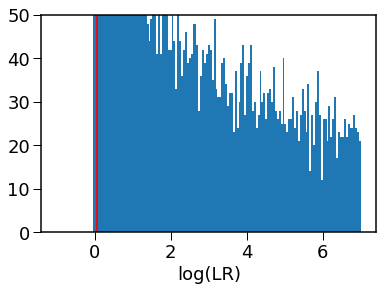

In [211]:
threshold_fin = th_runs[-1]
# threshold_fin = np.nanpercentile(final["lr_fin"], 100*(1 - Q0))
print("Q0: " + str(Q0))
print("Final Threshold: ", threshold_fin)

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_fin"])])))

print("No of sources below 0.1: " + 
      str(len(final["lr_fin"][final["lr_fin"] < 0.1])))

vlow_lr_k = final["lr_fin"][final["lr_fin"] < 0.1]
varstat(vlow_lr_k)

print("No of sources below threshold: " + 
      str(len(final["lr_fin"][final["lr_fin"] <=threshold_fin])))

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_fin"]), 0.05)
plt.hist(final["lr_fin"][~np.isnan(final["lr_fin"])], bins=lr_be)
plt.axvline(threshold_fin, 0, 1, color='r')
plt.ylim([0., 50])

#plt.yscale('log')
plt.xlabel('log(LR)')
# plt.xscale('log')

Cross-over threshold from the final run: 0.045


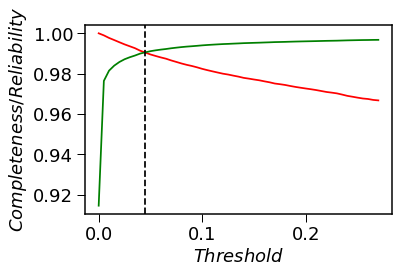

In [212]:
# Compute the completeness and reliability and plot them
thresholds = np.arange(0., 5 * threshold_fin, 0.005)
th_cross, completeness_t, reliability_t = comp_rel_threshold(final["lr_fin"], thresholds, Q0)

print("Cross-over threshold from the final run: {0}".format(th_cross))

fig = plt.figure()
plt.plot(thresholds, completeness_t, "r-")
plt.plot(thresholds, reliability_t, "g-")
# plt.plot(thresholds, average_t, "k-")
plt.axvline(th_cross, color="k", ls="--")
plt.xlabel(r"$Threshold$")
plt.ylabel(r"$Completeness/Reliability$")
# plt.xscale('log')
plt.tight_layout()
plt.savefig(outdir_name+"/completeness_reliability_fin.pdf")
# plt.close()

In [213]:
# Take the fraction of sources which have a LR above threshold compared with the no. of radio
# sources that had a match around lop_opt_radius
lr_above_th = ((~np.isnan(final["lr_fin"])) & (final["lr_fin"] >= threshold_fin))
print(np.sum(lr_above_th)/len(final))

0.911748627386


In [214]:
outdir_name

'full_runs_gaul_workflow/21_06_2019_1'

In [215]:
# Save the results by copying the LR results to the FULL deepfull catalogue
deepfull["lr_fin"] = np.nan
deepfull["lr_dist_fin"] = np.nan
deepfull["lr_index_fin"] = np.nan

# Set all sources below the threshold to be nan? - NEED TO DO THIS WHEN RUNNING IT PROPERLY
print("NOT SETTING THE SOURCES BELOWT THRESHOLD TO NaNs!")

deepfull["lr_fin"][forlr_indx] = final["lr_fin"]
deepfull["lr_dist_fin"][forlr_indx] = final["lr_dist_fin"]
deepfull["lr_index_fin"][forlr_indx] = final["lr_index_fin"]

field = "EN1"

# Write the deepfull to file
deepfull.write(outdir_name + "/" + field + "_ML_RUN_fin_overlap" + cat_type + ".fits", format='fits', overwrite=True)
# deepfull.write(outdir_name + "/" + field + "_ML_RUN_fin_overlap" + cat_type + ".txt", format='ascii', overwrite=True)

NOT SETTING THE SOURCES BELOWT THRESHOLD TO NaNs!


In [216]:
# Move the HTML notebook to the output directory
os.system("jupyter-nbconvert MaxL_RUN2_KDE.ipynb && mv MaxL_RUN2_KDE.html {0}".format(outdir_name))

0